# Finding the MRI brain tumour detection dataset

find the data set in this link: https://www.kaggle.com/datasets/masoumehsiar/siardataset

# Import packages

In [153]:
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2
import sys

# Reading images

In [21]:
tumour = []
tumour_path = './data/brain_tumour_dataset/yes/*.jpg'
for f in glob.iglob(tumour_path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img) #splitting the channels as cv2 reads in bgr format
    cv2.merge([r, g, b]) #merging the channels back in rgb format
    tumour.append(img)

healthy = []
healthy_path = './data/brain_tumour_dataset/no/*.jpg'
for f in glob.iglob(healthy_path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img) #splitting the channels as cv2 reads in bgr format
    cv2.merge([r, g, b]) #merging the channels back in rgb format
    healthy.append(img)

In [23]:
healthy = np.array(healthy)
tumour = np.array(tumour)
All = np.concatenate((healthy, tumour))

In [25]:
np.random.choice(10,5, replace=False)

array([1, 2, 0, 3, 8], dtype=int32)

# visualisation of the MRI images

In [28]:
def plot_random(healthy, tumour, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0],num, replace=False)]
    tumour_imgs = tumour[np.random.choice(tumour.shape[0],num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):#chopping num number of subplots
        plt.subplot(1, num, i+1)#using i+1 as plt uses 1 indexing
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):#chopping num number of subplots
        plt.subplot(1, num, i+1)#using i+1 as plt uses 1 indexing
        plt.title('tumour')
        plt.imshow(tumour_imgs[i])

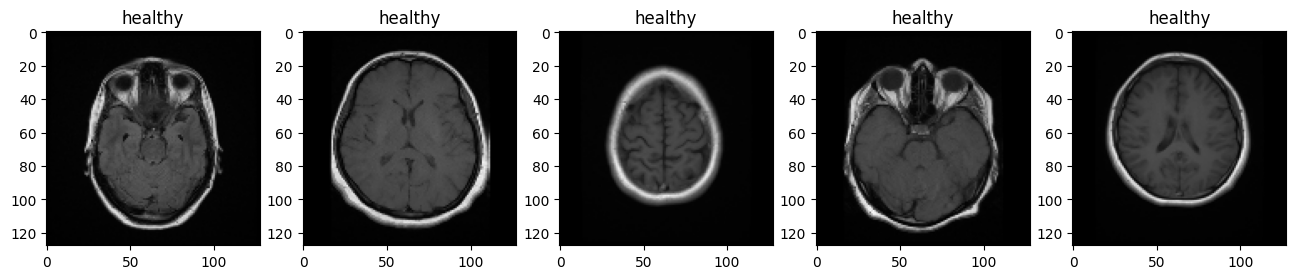

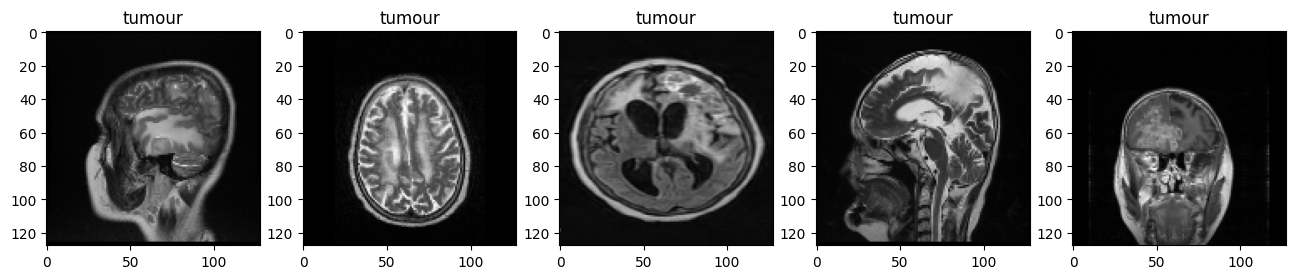

In [30]:
plot_random(healthy, tumour)

# pytorch dataset classes

In [33]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    
    def __len__(self):
        raise NotImplementedError
    
    def __add__(self, other):
        return ConcatDataset([self, other])

## MRI custom datases class

In [36]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumour_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumour_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [38]:
mri_dataset = MRI()
mri_dataset.normalize()

# Dataloader

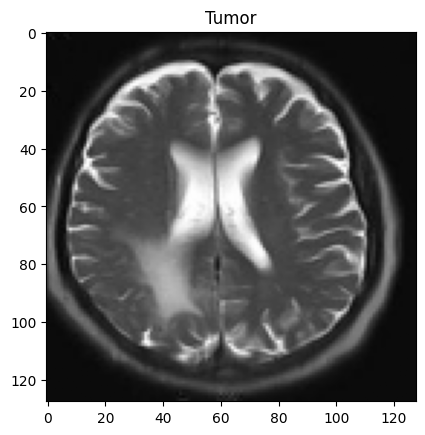

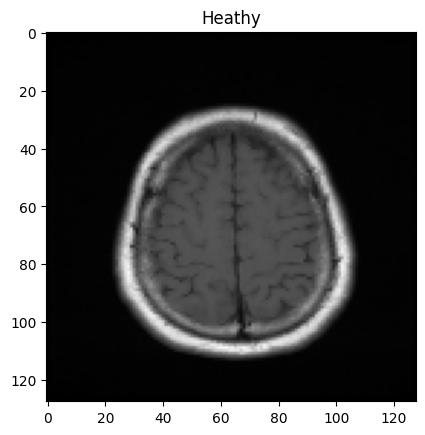

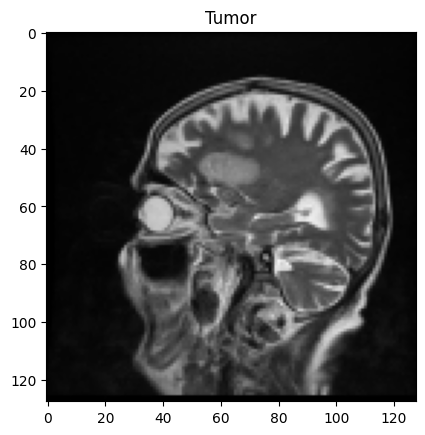

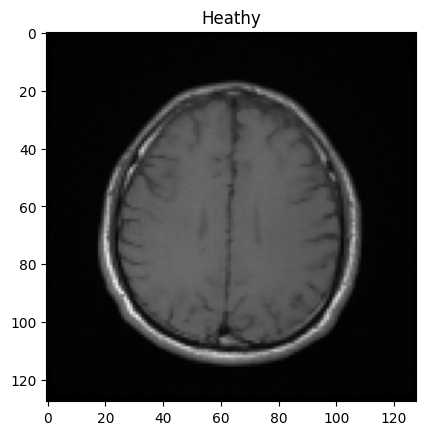

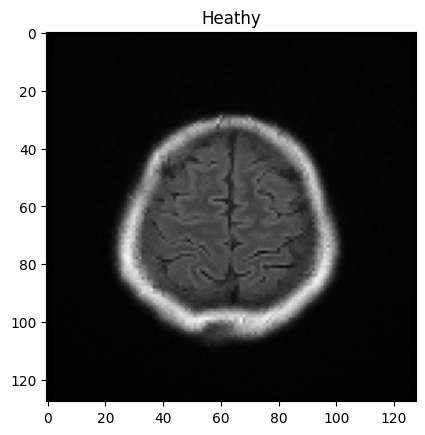

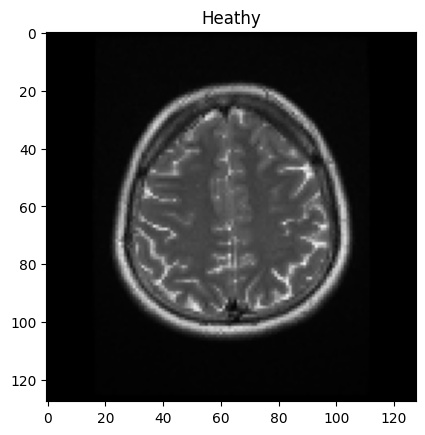

In [41]:
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# MODEL

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5)
        )
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),

        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        
        nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

# model parameters

In [47]:
model = CNN()

In [49]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [51]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [53]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [55]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[ 0.0013,  0.0165,  0.1078,  0.0437, -0.0740],
          [ 0.0269,  0.0008, -0.0943, -0.0573, -0.0118],
          [ 0.0935, -0.1086, -0.1038,  0.0934,  0.0073],
          [-0.0601,  0.0883,  0.0335,  0.0190,  0.0697],
          [-0.0070, -0.0348, -0.0797,  0.0821,  0.1045]],

         [[ 0.0631, -0.0560,  0.1073, -0.0985,  0.1004],
          [ 0.0256,  0.0353,  0.1095, -0.0773,  0.1006],
          [-0.0369, -0.0721, -0.0500,  0.0720,  0.0673],
          [-0.0750,  0.0458, -0.0643,  0.0759,  0.0939],
          [-0.0729,  0.0138,  0.0352, -0.1052, -0.0249]],

         [[-0.0783,  0.0835, -0.1135,  0.0155,  0.0548],
          [ 0.0014,  0.1118,  0.0539,  0.0509, -0.0978],
          [-0.0505, -0.0021,  0.1028,  0.0758,  0.0294],
          [ 0.0052, -0.1025,  0.0083,  0.1058,  0.0632],
          [-0.1080, -0.0085, -0.0048, -0.1034,  0.0557]]],


        [[[ 0.0474, -0.1022,  0.0887,  0.0130, -0.0852],
          [ 0.0633, -0.0730, -0.0543,  0.0663, -0.1151],
 

In [57]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [59]:
model.cnn_model[0].weight[0]

tensor([[[ 0.0013,  0.0165,  0.1078,  0.0437, -0.0740],
         [ 0.0269,  0.0008, -0.0943, -0.0573, -0.0118],
         [ 0.0935, -0.1086, -0.1038,  0.0934,  0.0073],
         [-0.0601,  0.0883,  0.0335,  0.0190,  0.0697],
         [-0.0070, -0.0348, -0.0797,  0.0821,  0.1045]],

        [[ 0.0631, -0.0560,  0.1073, -0.0985,  0.1004],
         [ 0.0256,  0.0353,  0.1095, -0.0773,  0.1006],
         [-0.0369, -0.0721, -0.0500,  0.0720,  0.0673],
         [-0.0750,  0.0458, -0.0643,  0.0759,  0.0939],
         [-0.0729,  0.0138,  0.0352, -0.1052, -0.0249]],

        [[-0.0783,  0.0835, -0.1135,  0.0155,  0.0548],
         [ 0.0014,  0.1118,  0.0539,  0.0509, -0.0978],
         [-0.0505, -0.0021,  0.1028,  0.0758,  0.0294],
         [ 0.0052, -0.1025,  0.0083,  0.1058,  0.0632],
         [-0.1080, -0.0085, -0.0048, -0.1034,  0.0557]]],
       grad_fn=<SelectBackward0>)

In [61]:
model.cnn_model[0].weight[0].shape

torch.Size([3, 5, 5])

In [63]:
model.cnn_model[0].weight[0][0]

tensor([[ 0.0013,  0.0165,  0.1078,  0.0437, -0.0740],
        [ 0.0269,  0.0008, -0.0943, -0.0573, -0.0118],
        [ 0.0935, -0.1086, -0.1038,  0.0934,  0.0073],
        [-0.0601,  0.0883,  0.0335,  0.0190,  0.0697],
        [-0.0070, -0.0348, -0.0797,  0.0821,  0.1045]],
       grad_fn=<SelectBackward0>)

In [65]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.1859, 0.1228, 0.6557, 0.8717, 0.3030, 0.9608, 0.0392, 0.6588, 0.2958,
        0.9048]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.1859, 0.1228, 0.6557, 0.8717, 0.3030, 0.9608, 0.0392, 0.6588, 0.2958,
        0.9048]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.0346, 0.0151, 0.4300, 0.7598, 0.0918, 0.9232, 0.0015, 0.4340, 0.0875,
        0.8186])


## Evaluating the new NN

In [68]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model = CNN().to(device)

In [69]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [72]:
model.eval()
outputs = []
y_true = []

with torch.no_grad(): #not computing the gradient to save the overhead
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
    
        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [74]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [76]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

#### accuracy score

In [79]:
accuracy_score(y_true, threshold(outputs))

0.4572245043757814

#### confusion matrix

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

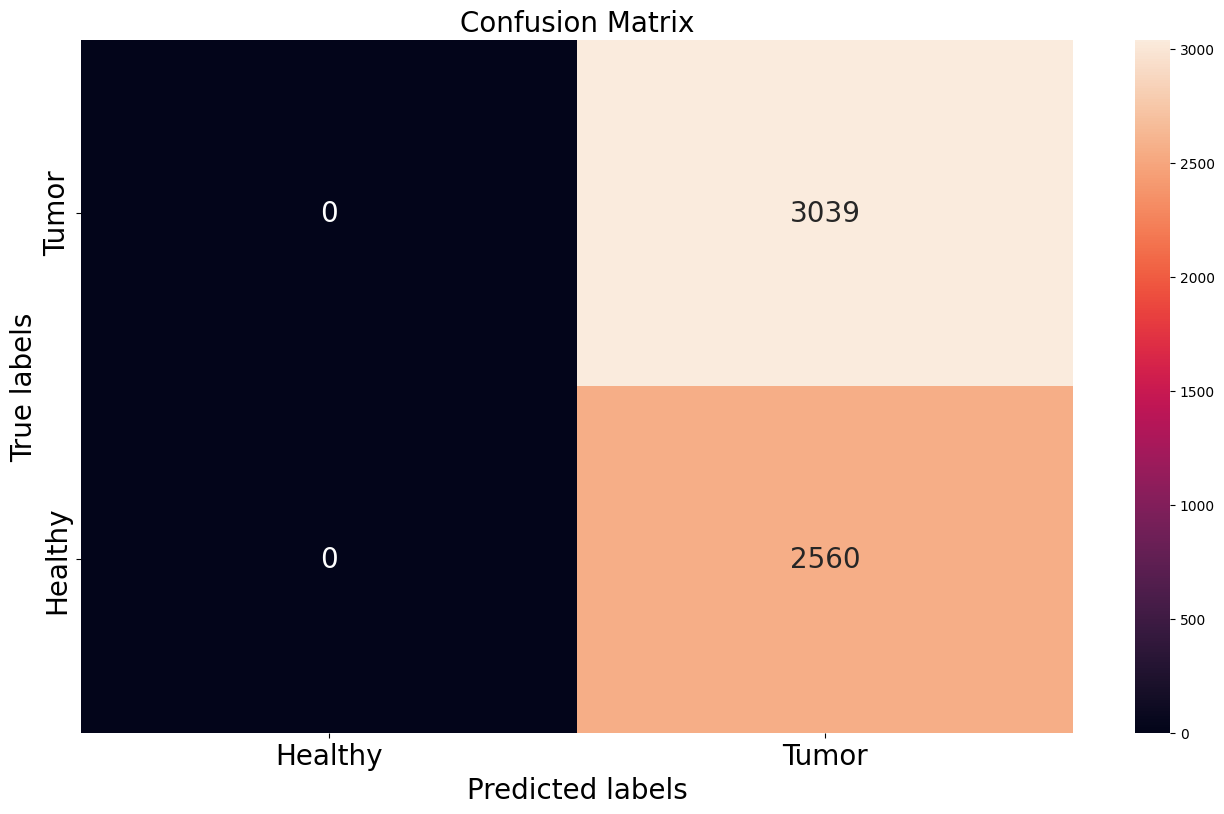

In [82]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

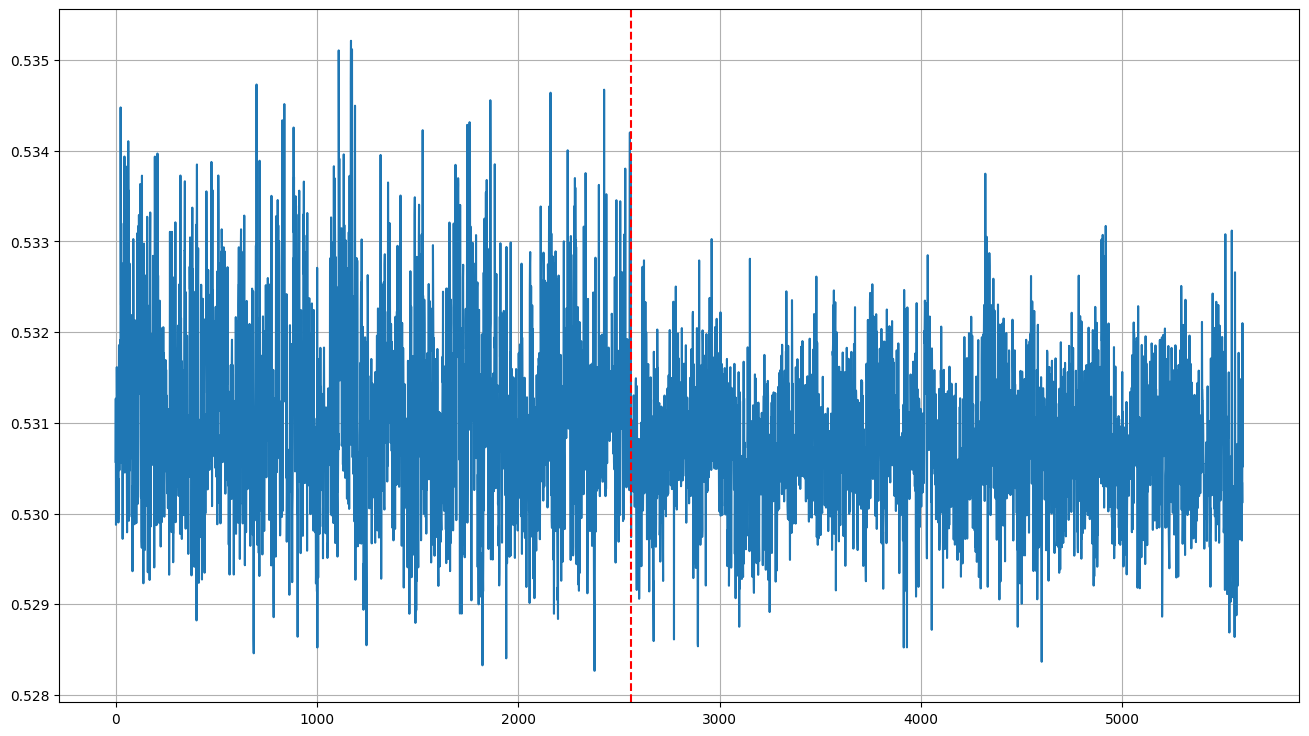

In [84]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumour), color='r', linestyle='--')
plt.grid()

## Training the model

In [87]:
eta = 0.0001
EPOCH = 50
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [88]:
for epoch in range(1, EPOCH):
    losses=[]
    for D in dataloader:
        optimizer.zero_grad() #ensuring nothing is cached before feeding the data
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)

        #loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 5	Loss: 0.286283
Train Epoch: 10	Loss: 0.240778
Train Epoch: 15	Loss: 0.216023
Train Epoch: 20	Loss: 0.199789
Train Epoch: 25	Loss: 0.190913
Train Epoch: 30	Loss: 0.182325
Train Epoch: 35	Loss: 0.176738
Train Epoch: 40	Loss: 0.171933
Train Epoch: 45	Loss: 0.168132
Train Epoch: 50	Loss: 0.162623


## Evaluating the trained model

In [92]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

#### accuracy score

In [95]:
accuracy_score(y_true, threshold(outputs))

0.9467762100375067

#### confusion matrix

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

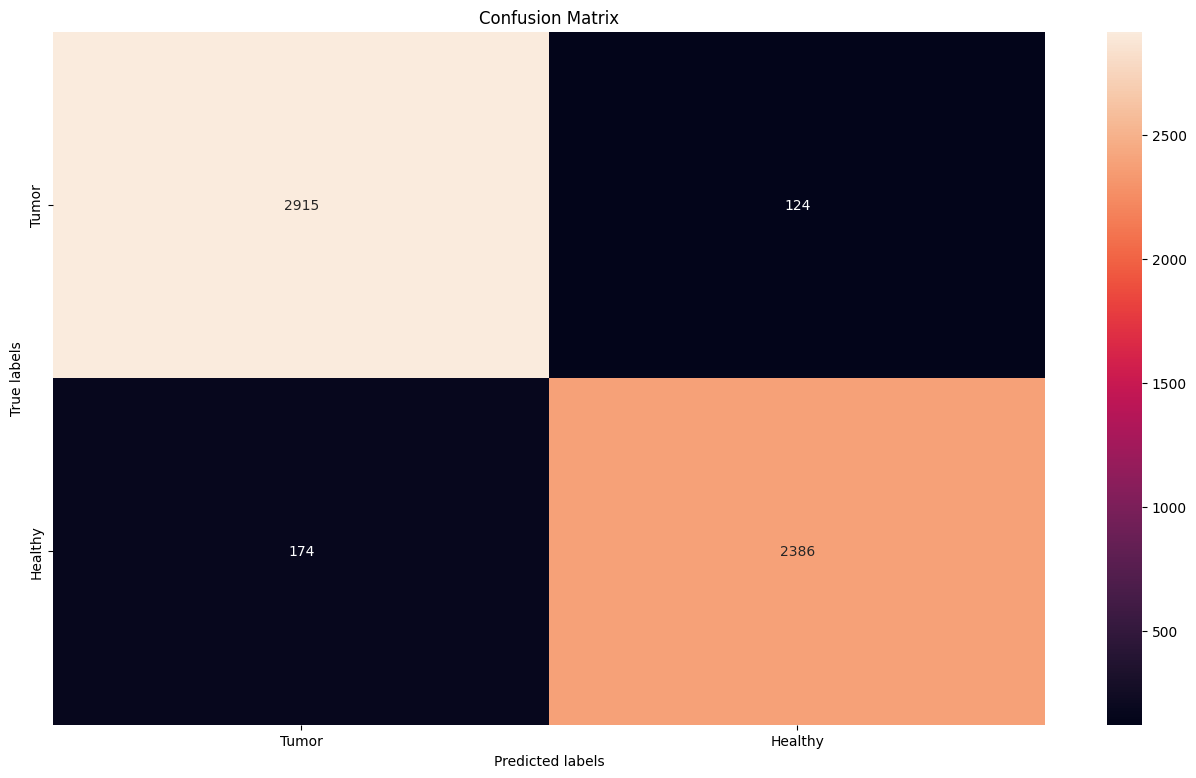

In [98]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

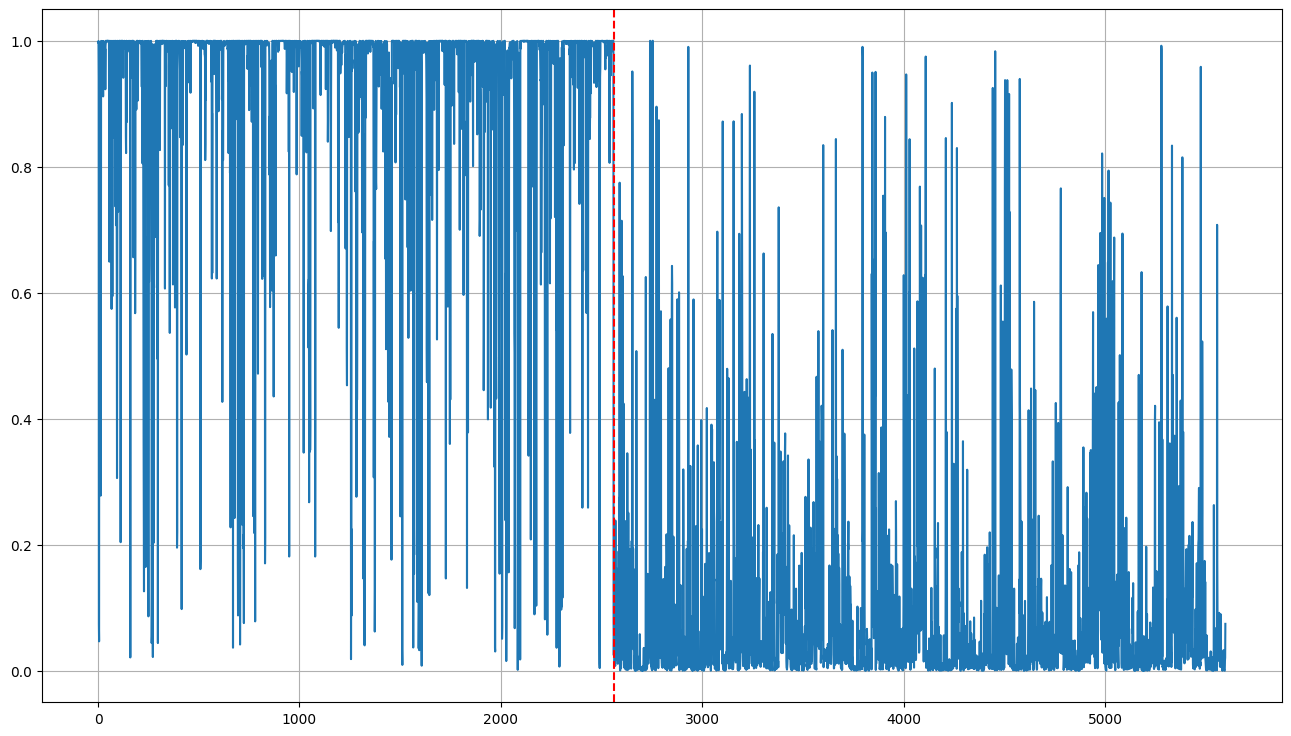

In [100]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumour), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [103]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [105]:
no_of_layers = 0
conv_layers = []

In [107]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [109]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [111]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

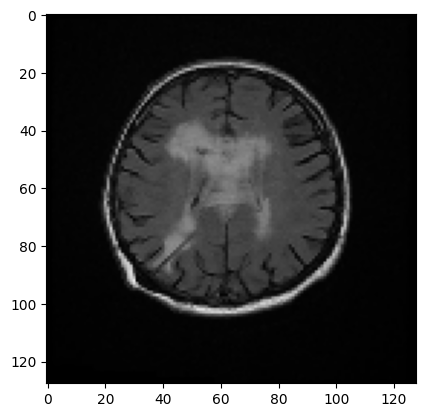

In [113]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [115]:
img = torch.from_numpy(img).to(device)

In [117]:
img.shape

torch.Size([3, 128, 128])

In [119]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [121]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


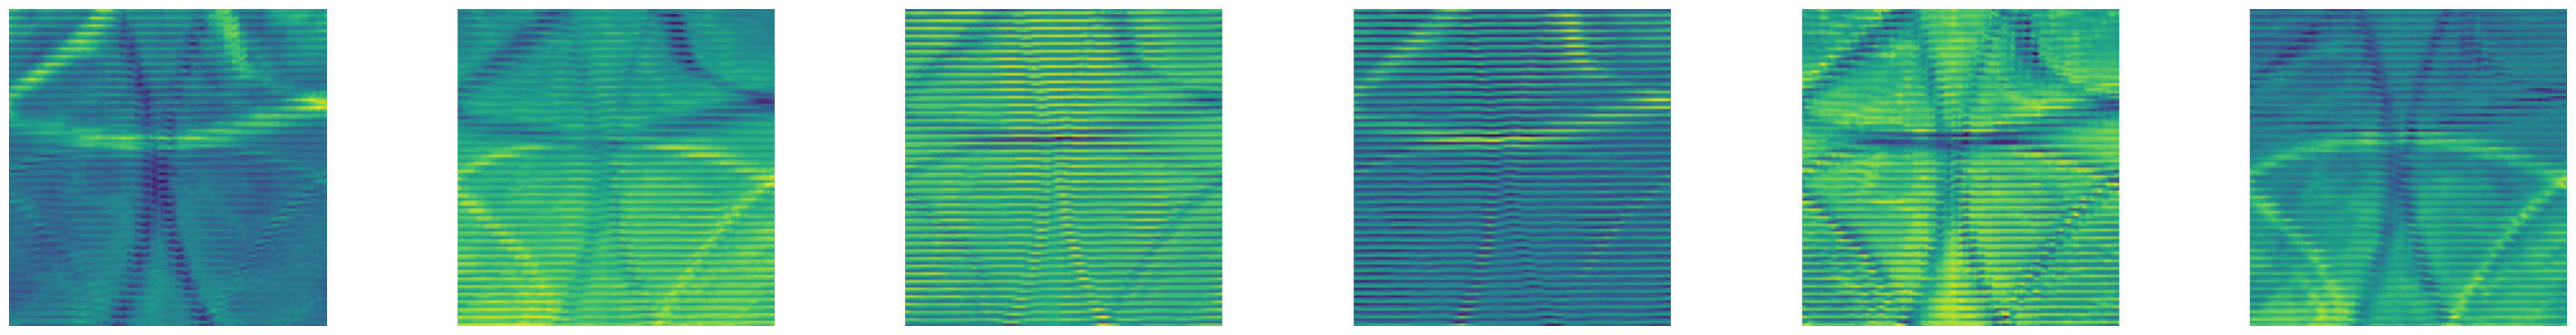

Layer  2


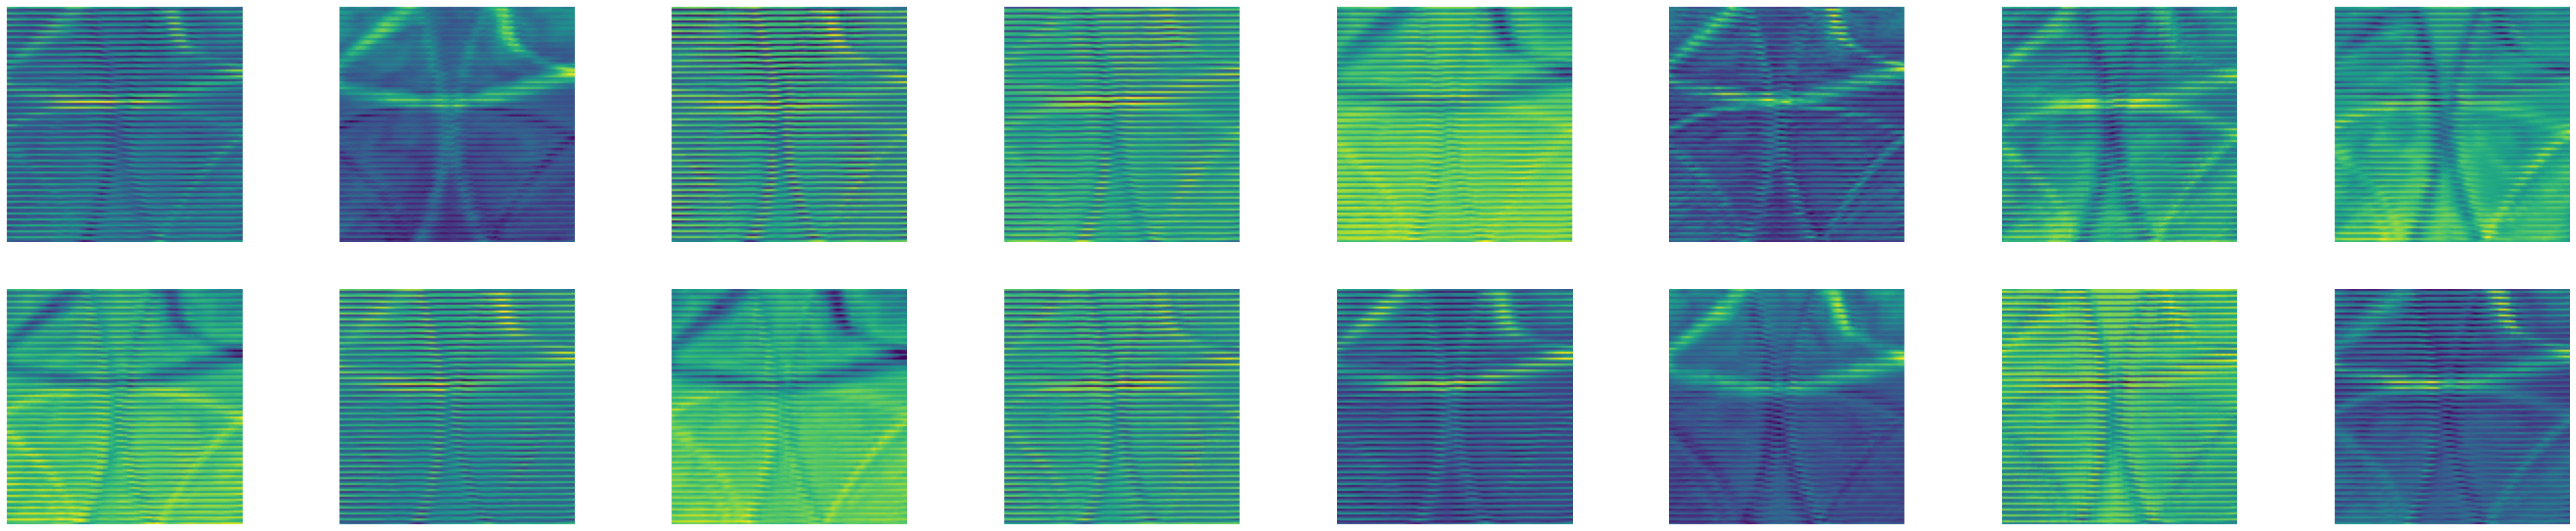

In [123]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Checking overfitting

### preparing validation set and neccessary changes to the dataset

In [127]:
from sklearn.model_selection import train_test_split

In [129]:
class MRI(Dataset):
    
    def __init__(self):
        
        # variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        #variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumour_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumour_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        #images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        #labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        #concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # function that would separate the data into training and validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # using self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # using self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [131]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [133]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [135]:
device = torch.device("cpu")
model = CNN().to(device)

In [137]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [139]:
#epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [141]:
for epoch in range(1,60):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.271493	Val Loss: 0.265669
Train Epoch: 20	Train Loss: 0.213422	Val Loss: 0.232838
Train Epoch: 30	Train Loss: 0.188003	Val Loss: 0.213761
Train Epoch: 40	Train Loss: 0.176263	Val Loss: 0.203149
Train Epoch: 50	Train Loss: 0.170074	Val Loss: 0.203029
Train Epoch: 60	Train Loss: 0.163467	Val Loss: 0.197384


Text(0, 0.5, 'Loss')

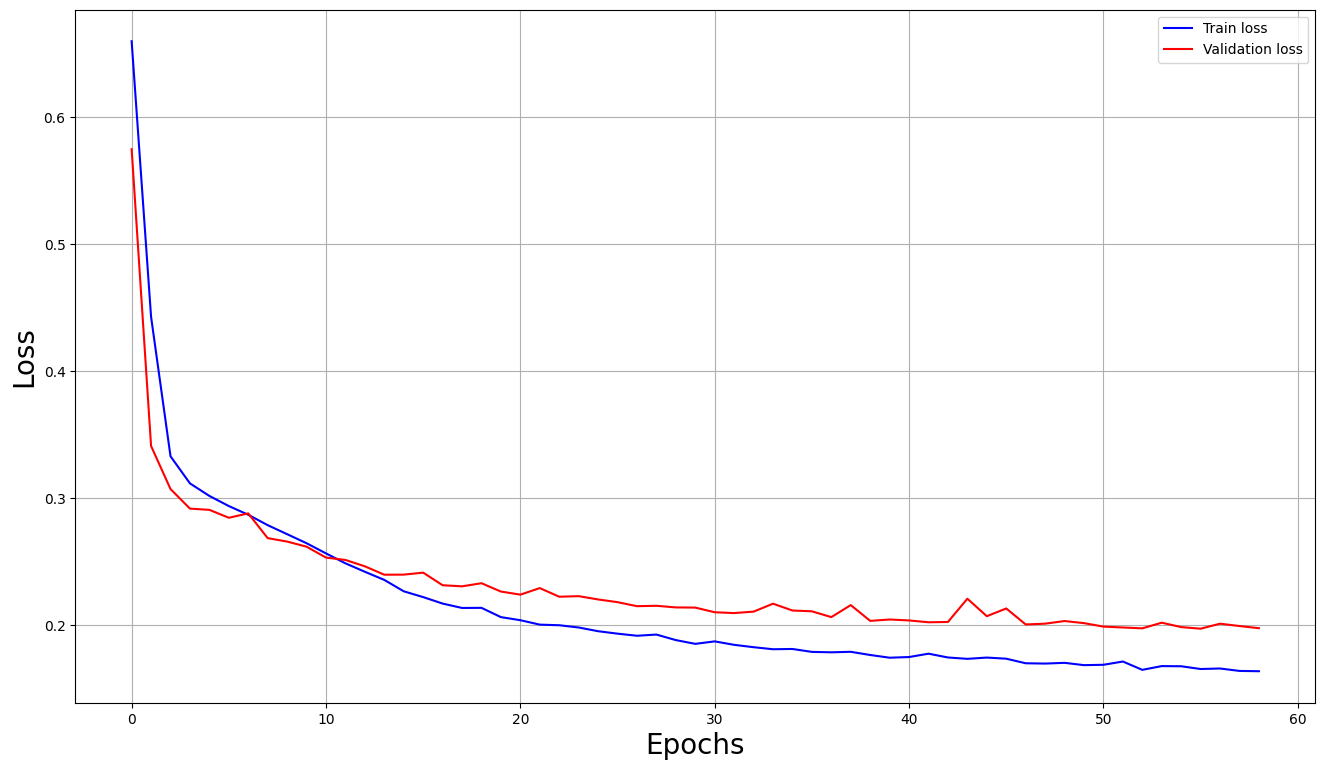

In [143]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

# Testing

In [146]:
class TestMRI(Dataset):
    def __init__(self, root_dir):
        self.images = []
        self.labels = []

        for f in glob.iglob(f"./data/testData/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            self.images.append(img)
            self.labels.append(1.0)

        for f in glob.iglob(f"./data/testData/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            self.images.append(img)
            self.labels.append(0.0)

        self.images = np.array(self.images, dtype=np.float32) / 255.0
        self.labels = np.array(self.labels, dtype=np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return {
            'image': torch.tensor(self.images[index]),
            'label': torch.tensor(self.labels[index])
        }


In [148]:
test_dataset = TestMRI('./testData')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [155]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for sample in test_loader:
        inputs = sample['image'].to(device)
        labels = sample['label'].to(device)

        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
print("🧩 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ Test Accuracy: 91.86%

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       760
         1.0       0.93      0.89      0.91       640

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400

🧩 Confusion Matrix:
[[716  44]
 [ 70 570]]


In [157]:
torch.save(model.state_dict(), 'model/model_weights.pth')